<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/IA20231_trabajo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary advances of non supervised clustering algorithms

We began by installing (if needed) and load the libraries required for the work. Is worth noting that the clustering algorithms are implementend _from scratch_, whereas the transformation of the dimensions of the space is made by employing well-known libraries such as `keras` and `umap`.

In [87]:
!pip install umap-learn

import numpy as np
import pandas as pd
import time

# Required for smart mountain clustering.
from itertools import combinations
# Plots.
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
# MLP required for build and autoenconder for feature extraction.
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
# Uniform Manifold Approximation and Projection (UMAP) Dimensionality Reduction.
import umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## On the selected data
For this work we employ to datasets. The first one is the `iris dataset`, a widely used dataset in popular programing languajes for statistics and ML such as `R` and `python`. This dataset has $N = 150$ observations $n=4$ features (sepal length, sepal width, petal length and petal width all in cms) and one output ($m=1$) which indicates to which of the three classes does the iris belong (Setosa, Versicolour and Virginica). This dataset will be used in the _exploration phase_, where is expected to understand the algorithms in the original space of the data (at least we assume that). Latter, in the _final phase_ we will employ a simulated dataset with three balanced clusters ($N=300$) in a five-dimensional space ($n=5$), the output is the label of the cluster of each instance ($m=1$). This dataset has the property that the clusters are mutually exclusive in some 3d-projections while in others overlaps. 

Working with simulated data allow us to known the real parameters of the data, then we will known with certainaty if a technique/error measure is working property and which is the optimal parameterization. Ofcourse the analysis of one dataset cannot provided general conclussions that are true to all datasets, since each data set belongs to a certained data generator process that lies in one of infinite topological spaces. Nevertheless, the analysis will provided important insighs on understanding the advantages and drawback of each algorithms and metric.

Is worth noting that both data sets are generated/loaded with the function `data_loader` and normalized with the function `normalizer`, which applies the transformation $\frac{x_i - \min{x_i}}{\max{x_i} - \min{x_i}}$ for each features (or variable).

In [88]:
def normalizer(data: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    return (data - data.min()) / (data.max() - data.min())

def data_loader(data_type: str):
    data_type = data_type.lower()
    if data_type == 'toy':
        df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                        header=None, 
                        names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
        features = df.drop('species', axis=1)
        features = normalizer(features).values
        labels = df['species']
        labels = np.array([0 if i == 'Iris-setosa' else 1 if i == 'Iris-versicolor' else 2 for i in labels])

        data = np.copy(features)
        data = pd.DataFrame(data)
        data['labels'] = labels
        return data, features, labels

data, features, labels = data_loader('toy')


## Distance Matrix

We implement from scratch the $p$-norm, cosine and Mahalanobis distances for two pair of vectors. With this we build a distance matrix of dimension $N \times N$ which has in the position $i,j$ the distance between the observation $i$ and the observation $j$. 

Special comments must be stressed to the cosine and Mahalanobis distances. Let $\vec u, \vec v \in R^n$ two vectors, the cosine distance is defined as $d_{cosine}(\vec u, \vec v) = 1-S_c(\vec u, \vec v)$, where $S_c(\vec u, \vec v) = \frac{\langle \vec u, \vec v \rangle}{ \|\vec u \|_2 \|\vec v\|_2}$. Notice that if $\|\vec u \|_2 = 0$ or $\|\vec v\|_2 = 0$ the distance is not defined but tends towards to infinite, so a special treatment must be done in this cases.

By its part, the Mahalanobis distance is defined for two vectors as $d^2(\vec u, \vec v) =  (\vec u - \vec v)^T S^{-1} (\vec u - \vec v)$, where $S^{-1}$ is the inverse of the covariance matrix of $\vec u$ and $\vec v$. Is clear that this do not exist if $S$ is singular. Hence, to guarantee the existance of the Mahalanobis distance for any pair of vectors, we employ the pseudo inverse of Moore-Penrose. Even so, if $S$ is very poor conditioned, the computation will give bad results, even NEGATIVE numbers, so a correction must be done to assure the non-negative property of the distances.

The heatmap for the Mahanthan ($p=1$), euclidean ($p=2$), infinite ($p → \infty$), cosine and Mahalanobis distances are preseted in the following figure, where is clear from the $p$-distances that there are three groups, whereas the cosine distance detects two groups and the Mahalanobis distances doesn't show any clear cluster, possibly due to the computational problems.

**Note:** The $p$-distance is defined as $d_p(\vec u, \vec v) = \left[\sum_{i=1}^n |(\vec u_i - \vec v_i)^p \right]^{\frac{1}{p}}$.

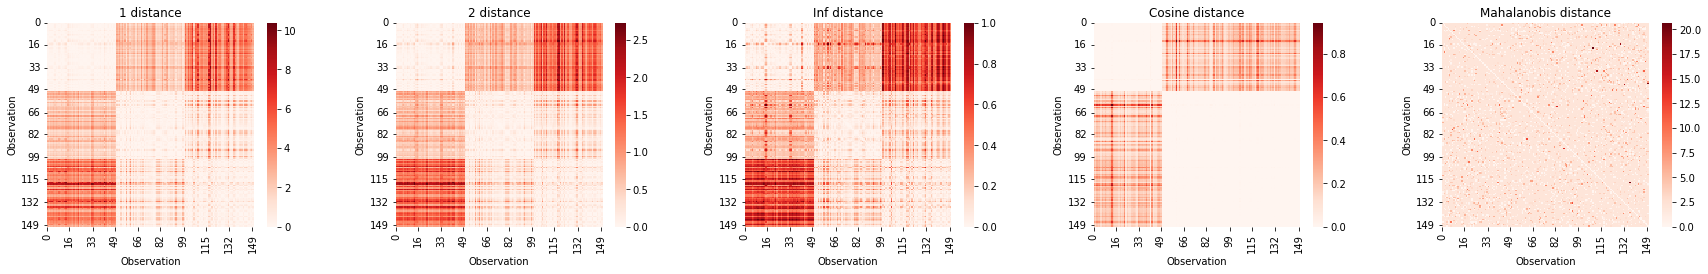

In [89]:
def cosineDistance(u: np.ndarray, v: np.ndarray) -> float or int:
    Sc = np.dot(u, v) / (np.linalg.norm(u, ord=2) * np.linalg.norm(v, ord=2))
    # Check if Sc is NaN
    if np.isnan(Sc):
        return np.inf
    else:
        return np.max([(1 - Sc)**2, 0])

def mahalanobis(u: np.ndarray, v: np.ndarray) -> float or int:
    cov = np.cov(np.array([u, v]).T)
    # Compute the inverse of the covariance matrix or the pseudo-inverse if the matrix is singular.
    try:
        vi = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        vi = np.linalg.pinv(cov)
    delta = u - v
    return np.max([np.dot(np.dot(delta, vi), delta), 0])

def p_norm(x: np.ndarray, p:float=2) -> float or int:
    if p == np.inf:
        return np.max(np.abs(x))**2
    else:
        return np.sum(np.abs(x)**p)**(2/p)

    
def distance(u: np.ndarray, v: np.ndarray,
             type: str or float or int) -> float or int:
    u = u.squeeze()
    v = v.squeeze()
    if u.ndim == 1 and v.ndim == 1:
        if isinstance(type, float) or isinstance(type, int):
            return p_norm(u - v, type)
        elif isinstance(type, str):
            if type.lower() in ['mahal', 'mahalanobis']:
                return mahalanobis(u, v)
            elif type.lower() in ['cosine', 'cos']:
                return cosineDistance(u, v)
            else:
                raise ValueError("Invalid type.")
    else:
        raise ValueError("u and v must be vectors.")
    
def distanceMatrix(x, type):
    if x.ndim==2:
        n = x.shape[0]
        d = np.empty((n, n))
        for i in range(n):
            for j in range(n):
                u = x[i,:].squeeze()
                v = x[j,:].squeeze()
                if isinstance(type, float) or isinstance(type, int):
                    d[i,j] = p_norm(u - v, type)

                elif isinstance(type, str):
                    if type.lower() in ['mahal', 'mahalanobis']:
                        d[i,j] = mahalanobis(u, v)

                    elif type.lower() in ['cosine', 'cos']:
                        d[i,j] = cosineDistance(u, v)
                    else:
                        raise ValueError("Invalid type.")
                else:
                    raise ValueError("Invalid type.")
                
        return d

def plot_distanceMatrix(x, types):
    fig, axes = plt.subplots(1,len(types), figsize=(len(types)*5,5))
    ticks = np.linspace(0, x.shape[0]-1, 10, dtype=np.int32)

    for type, ax in zip(types, axes.flat):
        d = distanceMatrix(x, type)
        sns.heatmap(d, linewidth=0 , cmap='Reds', ax=ax)
        ax.set_title(f'{str(type).title()} distance')

        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticks)

        ax.set_xlabel('Observation')
        ax.set_ylabel('Observation')

    plt.rcParams.update({'font.size': 10})
    plt.tight_layout(pad=5)
    plt.show()


dist_types = [1, 2, np.inf, 'cosine', 'mahalanobis']
plot_distanceMatrix(features, dist_types)

In [16]:
def add_neighbor(neighbours, neighbor):
    if neighbours.size == 0:
        neighbours = np.vstack([neighbours, neighbor])
    else:
        # Add the neighbor if it is not already in the neighbours array.
        if not np.any((neighbours == neighbor).all(axis=1)):
            neighbours = np.vstack([neighbours, neighbor])
        
    return neighbours

def get_neighbors(point, ubs, lbs):
    if point.ndim > 1:
        point = point.squeeze()
    if point.ndim == 1:
        # Initialize the neighbours array
        neighbours = np.empty((0, point.shape[0]))
        # Get the number of dimensions.
        ndim = point.shape[0]

        for i in range(ndim+1):
            for I in combinations(range(ndim),i):
                # Make indexes to stay in the same value.
                I = list(I)
                I1 = [x for x in range(ndim) if x not in I]
                for j in range(len(I1)):
                    for I0 in combinations(I1, j):
                        I0 = list(I0)
                        I1 = [x for x in I1 if x not in I0]
                      
                        if (np.all(point[I] - 1 >= lbs[I]) and np.all(point[I1] + 1 <= ubs[I1])) or\
                            (I==[] and np.all(point[I1] + 1 <= ubs[I1])) or \
                                (np.all(point[I] - 1 >= lbs[I]) and I1==[]):
                            neighbor = point.copy()
                            neighbor[I] = point[I] - 1
                            neighbor[I1] = point[I1] + 1
                            neighbours = add_neighbor(neighbours, neighbor)

                        if (np.all(point[I] - 1 >= lbs[I]) and np.all(point[I1] - 1 >= lbs[I1])) or\
                            (I==[] and np.all(point[I1] - 1 >= lbs[I1])) or \
                                (np.all(point[I] - 1 >= lbs[I]) and I1==[]):
                            neighbor = point.copy()
                            neighbor[I] = point[I] - 1
                            neighbor[I1] = point[I1] - 1
                            neighbours = add_neighbor(neighbours, neighbor)

                        if (np.all(point[I] + 1 <= ubs[I]) and np.all(point[I1] + 1 <= ubs[I1])) or\
                            (I==[] and np.all(point[I1] + 1 <= ubs[I1])) or \
                                (np.all(point[I] + 1 <= ubs[I]) and I1==[]):
                            neighbor = point.copy()
                            neighbor[I] = point[I] + 1
                            neighbor[I1] = point[I1] + 1
                            neighbours = add_neighbor(neighbours, neighbor)
                        I1 = [x for x in range(ndim) if x not in I]
                        
            

        return neighbours
    else:
        raise ValueError("point must be a vector.")

def makehullndgrid(x, n_grid):
    ndim = x.shape[1]

    hull_grid = (n_grid-1) * x
    # round the poin/ts to the nearest integer
    hull_grid = np.round(hull_grid).astype(int)

    points = np.copy(hull_grid)
    for i in range(points.shape[0]):
        # Get neighbors of the point inside the convex hull.
        point, points = points[-1, :], points[:-1, :]

        neighbors = get_neighbors(point, ubs=(n_grid-1)*np.ones(ndim), lbs=np.zeros(ndim))
        # Add neighbors to the grid '= they are not already there.
        for neighbor in neighbors:
            if not np.any((hull_grid == neighbor).all(axis=1)):
                hull_grid = np.vstack([hull_grid, neighbor])

    hull_grid = np.unique(hull_grid, axis=0)
    
    return hull_grid / (n_grid-1)

## Clustering algorithms
On this paper we explore four classical clustering algorithms (mountain, substractive, $k$-means, Fuzzy-$c$-means) and one proposed by the author jointly with my partners Salomón Cardeño and Federico Banoy.

Is worth noting that the mountain and substractive algorithms are implemented with two variations, one that recivies as parameter the number of clusters and other that determines the number of optimal clusters considering multiples stop criteria proposed by the author (probably as well by the literature). During this section, the code will have a good parameterization calibrated by hand, analyzing the efect of certain parameters on the visual performance of the algorithm.

In [123]:
def makendgrid(n_grid: int, ndim: int) -> np.ndarray:
    # Create a grid of n_grid points in each dimension that represents the hipercube [0,1]^ndim for a total of n^ndim points.
    meshgrid = np.array(np.meshgrid(*[np.linspace(0, 1, n_grid)]*ndim, indexing='ij'))
    return np.transpose(meshgrid.reshape(ndim,-1))

def mountain_clustering(
        x: np.ndarray, # Data matrix.
        n_grid: int, # Number of points in each dimension of the hypercube.
        k: int, # Number of clusters.
        sigma: int or float = 0, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2): # Distance type.
    n_obs, n_features = x.shape
    ncoords = n_grid**n_features
    if sigma == 0:
        sigma = 1 / n_grid

    if beta == 0:
        beta = 2*sigma

    # Create equally spaced coordinates in the hypercube [0,1]^n_features.
    if ncoords < 1e6:
        hypercube = makendgrid(n_grid, n_features)
        
        centers = np.zeros((k, n_features))
        idx_centers = np.zeros(k, dtype=np.int32)
        mount_centers = np.zeros(k)
        mountain = np.zeros(ncoords)
        for i in range(k):
            if i == 0:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] + np.exp(-distance(coord, x[j,:], dist_type) / (2*sigma**2))
            else:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] - mount_centers[i-1] * np.exp(-distance(coord, centers[i-1], dist_type) / (2*beta**2))
            
            idx_centers[i] = int(np.argmax(mountain))
            centers[i, :] = hypercube[idx_centers[i], :]
            mount_centers[i] = mountain[idx_centers[i]]

    else:
        hypercube = makefastndrid(n_grid, n_features)
    
    return centers, idx_centers, mount_centers, mountain


def mountain_clustering_olguis(
        x: np.ndarray, # Data matrix.
        n_grid: int, # Number of points in each dimension of the hypercube.
        sigma: int or float = 0, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2,
        hyper_type: str = 'hull',
        tol: float = 1e-1): # Distance type.
    n_obs, n_features = x.shape
    if sigma == 0:
        sigma = 1 / n_grid

    if beta == 0:
        beta = 2*sigma
    if hyper_type == 'hull':
        hypercube = makehullndgrid(x, n_grid=n_grid)
        ncoords = hypercube.shape[0]
    else:
        hypercube = makendgrid(n_grid, n_features)
        ncoords = n_grid**n_features

    # Create equally spaced coordinates in the hypercube [0,1]^n_features.
    if ncoords < 1e6:
        
        # hypercube = makendgrid(n_grid, n_features)
        # hypercube = makehullndgrid(x, n_grid=n_grid)
        # ncoords = hypercube.shape[0]
        
        k = 100
        centers = np.zeros((k, n_features))
        idx_centers = np.zeros(k, dtype=np.int32)
        mount_centers = np.zeros(k)
        mountain = np.zeros(ncoords)
        i = 0
        while True:
            if i == 0:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] + np.exp(-distance(coord, x[j,:], dist_type) / (2*sigma**2))
            else:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] - mount_centers[i-1] * np.exp(-distance(coord, centers[i-1], dist_type) / (2*beta**2))
            
            idx_centers[i] = int(np.argmax(mountain))
            new_center = hypercube[idx_centers[i], :]
            # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
            if any(np.equal(centers, new_center).all(axis=1)) or\
                abs(mountain[idx_centers[i]]) < min(tol, 0.5/(n_grid-1)):
                centers = centers[:i, :]
                idx_centers = idx_centers[:i]
                mount_centers = mount_centers[:i]
                break

            centers[i, :] = new_center
            mount_centers[i] = mountain[idx_centers[i]]
            i = i + 1

    else:
        raise ValueError('The number of coordinates is too large.')
        # hypercube = makefastndrid(n_grid, n_features)
    
    return centers, idx_centers, mount_centers, mountain

def reduction(
        x: np.ndarray, # Data matrix.
        k: int, # Number of clusters.
        sigma: int or float, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2): # Distance type.
    n_obs, n_features = x.shape

    if beta == 0:
        beta = 2*sigma

        
    centers = np.zeros((k, n_features))
    idx_centers = np.zeros(k, dtype=np.int32)
    density_centers = np.zeros(k)
    density = np.zeros(n_obs)
    for i in range(k):
        if i == 0:
            for j in range(n_obs):
                for l in range(n_obs):
                    density[j] = density[j] + np.exp(-distance(x[j,:], x[l,:], dist_type) / (sigma/2)**2)
        else:

            for j in range(n_obs):
                density[j] = density[j] - density_centers[i-1] * np.exp(-distance(x[j,:], centers[i-1], dist_type) / (beta/2)**2)
        
        idx_centers[i] = int(np.argmax(density))
        centers[i, :] = x[idx_centers[i], :]
        density_centers[i] = density[idx_centers[i]]


    
    return centers, idx_centers, density_centers, density


def reduction_olguis(
        x: np.ndarray, # Data matrix.
        sigma: int or float, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2, # Distance type.
        tol: float = 1e-3): # Tolerance parameter for the stop criteria.
    n_obs, n_features = x.shape

    if beta == 0:
        beta = 2*sigma

    k = 100
    centers = np.zeros((k, n_features))
    idx_centers = np.zeros(k, dtype=np.int32)
    density_centers = np.zeros(k)
    density = np.zeros(n_obs)

    i = 0
    while True:
        if i == 0:
            for j in range(n_obs):
                for l in range(n_obs):
                    density[j] = density[j] + np.exp(-distance(x[j,:], x[l,:], dist_type) / (sigma/2)**2)
        else:

            for j in range(n_obs):
                density[j] = density[j] - density_centers[i-1] * np.exp(-distance(x[j,:], centers[i-1], dist_type) / (beta/2)**2)
        
        idx_centers[i] = int(np.argmax(density))
        new_center = x[idx_centers[i], :]
        new_density = density[idx_centers[i]]
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if i > 0:
            if any(np.equal(centers, new_center).all(axis=1)) or\
                abs(new_density) < tol or\
                abs(new_density / density_centers[i-1]) < 1e-1:
                centers = centers[:i, :]
                idx_centers = idx_centers[:i]
                density_centers = density_centers[:i]
                break
        centers[i, :] = new_center
        density_centers[i] = new_density

        i = i + 1


    
    return centers, idx_centers, density_centers, density

def kmeans(
        x: np.ndarray, # Data matrix.
        k: int, # Number of clusters.
        max_iter: int = 100, # Maximum number of iterations.
        tol: float = 1e-3, # Tolerance parameter for the stop criteria.
        dist_type: str or float or int = 2, # Distance type.
        verbose: bool = False, # Verbose mode.
        init: list = []): # Initialization centers.
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)
        
        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1:
            if abs(cost - costs[iteration-2]) < tol or iteration > max_iter:
                break
        # Update the centers.
        for i in range(k):
            centers[i, :] = np.mean(x[membership[:, i] == 1, :], axis=0)

        iteration = iteration + 1

        if verbose:
            print('Iteration: ', iteration, 'Cost: ', cost)
        
    return centers, membership, costs

def fuzzyCmeans(
        x: np.ndarray, # Data matrix.
        k: int, # Number of clusters.
        m: int or float = 2, # Fuzziness parameter.
        max_iter: int = 100, # Maximum number of iterations.
        tol: float = 1e-3, # Tolerance parameter for the stop criteria.
        dist_type: str or float or int = 2, # Distance type.
        verbose: bool = False): # Verbose mode.
    n_obs, n_features = x.shape
    # Initialization the membership matrix.
    membership = np.random.rand(n_obs, k)
    membership = membership / np.sum(membership, axis=1, keepdims=True)

    iteration = 0
    centers = np.zeros((k, n_features))
    costs = np.zeros(max_iter+1)
    while True:
        # Calculate the centers.
        for i in range(k):
            centers[i, :] = membership[:, i] ** m @ x / np.sum(membership[:, i] ** m)

        # Compute the cost function.
        cost = 0
        for i in range(k):
            for j in range(n_obs):
                cost = cost + membership[j, i] ** m * distance(centers[i,:], x[j,:], dist_type)
        costs[iteration] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1:
            if abs(cost - costs[iteration-2]) < tol or iteration > max_iter:
                break
        # Update the membership matrix.
        for i in range(k):
            for j in range(n_obs):
                den = 0
                for l in range(k):
                    den = den + (distance(x[j,:], centers[i,:], dist_type) /\
                                 distance(x[j,:], centers[l,:], dist_type)) ** (2/(m-1))
                membership[j, i] = 1 / den

        iteration = iteration + 1

        if verbose:
            print('Iteration: ', iteration, 'Cost: ', cost)
    
    return centers, membership, costs

def plot_3Dcenters(data, centers, axis, title=None):
    names = data.columns
    fig = px.scatter_3d(data, x=names[i], y=names[j], z=names[k],\
                        color=names[-1], opacity=0.25, title=title)
    # Add the centers as big x's.
    # fig.add_scatter3d(x=centers[:, i], y=centers[:, j], z=centers[:, k], mode='markers',
    #                     marker=dict(size=2, color='black'))



    fig.add_scatter3d(x=centers[:,i], y=centers[:,j], z=centers[:,k], mode='markers',
                      marker=dict(size=2, color='black', symbol='x'))
    fig.show()

### Mountain

The mountain clustering is by far the slowest algorithm of all, since it creates a the unit hypercube with a granularity of $g$ (number of points per dimension) as potential candidates for centers. Clearly the size of the hypercube increase exponentially, in fact, for $n$ features, the hypercube will have $g^n$ points. This overloads the memory extremely fast. Furthermore, the algorithm must make calculations for each point so even with infinite memory this will increase the required time exponentially also. 

From the exploration, is clear that all the parameters must be in an intermediate value, that is, very low and very high parameters return bad results. It is interesting to observe that the $\sigma$ value depends on $g$. $\sigma$ can be interpreted as the influence radio to compute the mountain function for each center candidate, hence this parameter only has sense if $0 < \sigma < \frac{1}{g-1}$.

In [119]:
t = time.time()
centers, idx_centers, mount_centers, mountain = mountain_clustering_olguis(features, n_grid=6, sigma=0.09,\
                                                                           dist_type=2, hyper_type='all', tol=1e-2)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Elapsed time: 9.774304151535034


In [124]:
plot_3Dcenters(data, centers, (0, 1, 2), 'Mountain')

In [92]:
t = time.time()
centers, idx_centers, mount_centers, mountain = mountain_clustering(features, n_grid=6, k=3, sigma=0.05, dist_type=2)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Elapsed time: 9.889370203018188


In [93]:
plot_3Dcenters(data, centers, (0, 1, 2), 'k-Mountain')

### Substractive

The substractive clustering algorithm aims to solve the extremely high computational burden, for this it select as potential center candidates the data. It is evident that this has a computational cost that increase linearly on the number of candidates instead of exponentially on the dimensions of the data and the granularity. Sadly this is achieved at the expense of assuming that the real centers of the clusters are point on the data, an assumption that could be unrealistic.

Respect the parameters analysis, similar conclussions can be achieve, the only difference is that since we do not construct the hypercube the granularity is no a parameter for this algorithm, then we do not have a clear upper bound to the influence radio to compute the mountain function for each center candidate $r_a$. It worth noting that for equivalent clustering, $r_a = 8\sigma$. The above is supported theoretically and by experimentation.

In [94]:
t = time.time()
centers, idx_centers, density_centers, density = reduction_olguis(features, sigma=0.05*8, dist_type=2)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Elapsed time: 0.5303733348846436


In [95]:
plot_3Dcenters(data, centers, (0, 1, 2), 'Reduction')

In [96]:
t = time.time()
centers, idx_centers, density_centers, density = reduction(features, k=3, sigma=0.05*8, dist_type=2)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Elapsed time: 0.5027768611907959


In [97]:
plot_3Dcenters(data, centers, (0, 1, 2), 'k-Reduction')

### $k$-means and fuzzy-$k$-means
Conversely to the algorithms of mountain and subtractive, $k$-means and fuzzy-$c$-means do not require calibration of parameters since the number of clusters $k$ is given as a parameter. In consecuence, if the number of parameters is apriori known both algorithms guarantee in general better results, that is since the performance of mountain and substractive is sensitive to the parameterization. Nevertheless, in practice, the number of clusters is not always known or is "known" incorrectly. Therefore is essential for the modeller to make an extensive exploration of the space considering multiple techniques and constrast the results with the theory or opinion of experts on the data generating process.

In [98]:
t = time.time()
centers, membership, costs = kmeans(features, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=True)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Iteration:  1 Cost:  26.213397697287913
Iteration:  2 Cost:  8.792615870539686
Iteration:  3 Cost:  7.692967190446098
Iteration:  4 Cost:  7.330785626394259
Iteration:  5 Cost:  7.232621438200393
Iteration:  6 Cost:  7.200448847514465
Iteration:  7 Cost:  7.1826671327567295
Iteration:  8 Cost:  7.169111467307467
Iteration:  9 Cost:  7.151593675022099
Iteration:  10 Cost:  7.138647703985378
Elapsed time: 0.17998600006103516


In [56]:
plot_3Dcenters(data, centers, (0, 1, 2), 'k-means')

In [99]:
t = time.time()
centers, membership, costs = fuzzyCmeans(features, k=3, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=True)
elapsed = time.time() - t
print(f'Elapsed time: {elapsed}')

Iteration:  1 Cost:  18.401161236000405
Iteration:  2 Cost:  12.910566590054309
Iteration:  3 Cost:  6.458228010561807
Iteration:  4 Cost:  5.944557814697199
Iteration:  5 Cost:  6.010646514849048
Iteration:  6 Cost:  5.969861439451645
Iteration:  7 Cost:  5.941781447535082
Iteration:  8 Cost:  5.930109666554521
Iteration:  9 Cost:  5.928124463924521
Elapsed time: 0.5130844116210938


In [108]:
n_features = features.shape[1]
for comb in combinations(range(n_features), 3):
  plot_3Dcenters(data, centers, comb, f'Fuzzy-c-means: dimensions {comb}')

### Proposed algorithm: reduction
As mentioned above, the mountain clustering requires a massive amount of computational resources whereas the substractive assumes that the cluster centers are included in the dataset. In other words, each one solves the problems of the other, or in words of an economist, this algorithms are pareto efficent but none strictly dominates over the other. 

In the urge to find an algorithm that dominates over both and do not assume the number of clusters over the data. This author, jointly with my friends Salo and Fede, propose a modification to the mountain algorithm. The main idea is that if the data do not fill all the space, there well be gaps in the hypercube that will be far away from the nearest point, that is, the mountain function will be almost zero, then it will never be a center so can be deleted.

With this in mind, instead of making a unit hypercube, it is possible to build a $n$-dimensional grid subset of the hypercube that surrounds the data in an smart way. Given a granularity $g$, for all observations $x_i$, we find the nearest point in the hypercube $p^*$. Then, we surround this point by all its neighbors in the hypersphere with radio $r=\frac{\sqrt{2}}{g-1}$, centered on the point $p^*$ (see the first figure below). The union of all the neighbors and points $p^*$ will be the $n$ dimensional grid (see the second figure below).

As practical remarks, it must be said that if the granularity is very small is obvious that we will obtained the original hypercube (see the third figure below), that is, generalize the mountain algorithm for a small $g$, the case were it does not has computational problems. Meanwhile, if the granularity is higher it will be considerably smaller than the original hypercube offering considerable computational perks. It must be warned that a very high granularity is not be desirable, since the grid will start to surround each point at such degree that does not include other points (see the fourth figure below), namely, will make a "cluster" on each point. Obviously, all those extra grid point do not improve the estimation of the centers and add computational burden.

In [ ]:
point = np.array([5, 5, 5])
neigbours = get_neighbors(point, 10*np.ones(point.shape), np.zeros(point.shape))
neigbours

centers = pd.DataFrame(np.unique(neigbours, axis=0))
point = pd.DataFrame(point.reshape(1,-1))
neigbours.shape
fig = px.scatter_3d(point, x=0, y=1, z=2, opacity=0.25)
fig.add_scatter3d(x=centers[0], y=centers[1], z=centers[2], mode='markers',
                  marker=dict(size=2, color='black'))

fig.show()

In [130]:
def plot_3Dgrid(data, grid, axis, title=None):
    grid = pd.DataFrame(hull_grid)
    names = data.columns
    fig = px.scatter_3d(data, x=names[i], y=names[j], z=names[k],\
                        color=names[-1], opacity=0.25, title=title)
    fig.add_scatter3d(x=grid[i], y=grid[j], z=grid[k], mode='markers',
                        marker=dict(size=2, color='black'))

    fig.show()

n_grids = [11, 3, 50]
for n_grid in n_grids:
  hull_grid = makehullndgrid(features, n_grid=n_grid)
  print(f'# of obs in\n\tReduced grid shape: {hull_grid.shape[0]}\n\tOriginal hypercube shape: {n_grid**features.shape[1]}')
  plot_3Dgrid(data, hull_grid, (0, 1, 2), f'Reduced grid with a granularity of {n_grid}')

# of obs in
	Reduced grid shape: 2209
	Original hypercube shape: 14641


# of obs in
	Reduced grid shape: 81
	Original hypercube shape: 81


# of obs in
	Reduced grid shape: 10602
	Original hypercube shape: 6250000


# High dimensional space

In [136]:
input_layer = Input(shape=(features.shape[1],))
encoded = Dense(10, activation='sigmoid')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(features, features, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = False,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
features_high = normalizer(encoder.predict(X)).values

5/5 [==============================] - 0s 3ms/step


# Low dimensional space

In [139]:
fit = umap.UMAP(metric='euclidean',
                n_components=2,
                random_state=0,
                n_neighbors=5,
                min_dist=0.3)

features_low = fit.fit_transform(features)
features_low = normalizer(features_low).values